## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

## Choose Variables and Preprocess

In [2]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

# Filter to desired variables (numeric then categorical)
# pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH']]
# pums_data_p = p_df[['SERIALNO','AGEP','SEX','SCHL','COW']]
pums_data_h = h_df[['SERIALNO','HINCP','NP','VEH','BLD','ACCESS']]
pums_data_p = p_df[['SERIALNO','AGEP','JWMNP','SEX','SCHL','COW','DPHY','DEYE','DREM','DOUT','ESR','RAC1P']]
del h_df
del p_df
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)

# Sort by cont/cat, then by pers/hh
# pums_data = pums_data[['AGEP','HINCP','SCHL','COW','SEX','NP','VEH']]
pums_data = pums_data[['AGEP','HINCP','JWMNP','SCHL','COW','SEX','DPHY','DEYE','DREM','DOUT','ESR','RAC1P','NP','VEH','BLD','ACCESS']]

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")
pums_data

Dataset n=359075 pre-cleaning
Dataset n=150203 post-cleaning


,AGEP,HINCP,JWMNP,SCHL,COW,SEX,DPHY,DEYE,DREM,DOUT,ESR,RAC1P,NP,VEH,BLD,ACCESS
4,52,210500.0,70.0,21.0,1.0,1,2.0,2,2.0,2.0,1.0,1,3,3.0,2.0,1.0
5,51,210500.0,20.0,21.0,3.0,2,2.0,2,2.0,2.0,1.0,1,3,3.0,2.0,1.0
7,59,50310.0,30.0,19.0,3.0,1,2.0,2,2.0,2.0,1.0,1,2,3.0,1.0,3.0
8,56,50310.0,15.0,16.0,1.0,2,2.0,2,2.0,2.0,1.0,1,2,3.0,1.0,3.0
9,40,31200.0,5.0,5.0,1.0,1,2.0,2,2.0,2.0,1.0,9,5,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,37,55000.0,50.0,21.0,1.0,1,2.0,2,2.0,2.0,1.0,6,3,2.0,2.0,1.0
356010,33,102000.0,65.0,18.0,1.0,1,2.0,2,2.0,2.0,1.0,1,4,2.0,3.0,1.0
356013,48,106400.0,60.0,18.0,1.0,1,2.0,2,2.0,2.0,1.0,1,3,4.0,2.0,1.0
356014,49,106400.0,30.0,19.0,1.0,2,2.0,2,2.0,2.0,1.0,1,3,4.0,2.0,1.0


In [3]:
CAT_IDX = 3  # Index of first categorical var in all variables
HH_IDX = [1,12,13,14,15]  # Indices of household variables
LEN_PERS = pums_data_p.shape[1] - 1  # Number of person variables before OHE
LEN_HH = pums_data_h.shape[1] - 1  # Number of household variables before OHE
VAR_DIM = pums_data.shape[1]  # Length of all variables before OHE
VAR_NAMES = pums_data.columns  # Names of all variables before OHE
HH_VAR_NAMES = pums_data_h.columns  # Names of the hh variables

del pums_data_p
del pums_data_h

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
for x in range(CAT_IDX, VAR_DIM):
    dummies = pums_data.iloc[:,x]
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
    del dummies
CAT_LENGTHS = [x.shape[1] for x in dummies_list]
print(f"Categorical variable class lengths: {CAT_LENGTHS}")

Categorical variable class lengths: [24, 8, 2, 2, 2, 2, 2, 2, 9, 18, 7, 10, 3]


In [4]:
# Final data frame after encoding OHE
model_data_df = pums_data.iloc[:,:CAT_IDX]
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
del ohe_var
MANIFEST_DIM = model_data_df.shape[1]

# Add columns for original household variables; these will be fed to decoder but not encoder
model_data_df = pd.concat([model_data_df, pums_data.iloc[:,HH_IDX]], axis=1)

# Preview data that will be fed into model
model_data_df

,AGEP,HINCP,JWMNP,SCHL__1.0,SCHL__2.0,SCHL__3.0,SCHL__4.0,SCHL__5.0,SCHL__6.0,SCHL__7.0,...,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0,HINCP,NP,VEH,BLD,ACCESS
4,52,210500.0,70.0,0,0,0,0,0,0,0,...,0,0,1,0,0,210500.0,3,3.0,2.0,1.0
5,51,210500.0,20.0,0,0,0,0,0,0,0,...,0,0,1,0,0,210500.0,3,3.0,2.0,1.0
7,59,50310.0,30.0,0,0,0,0,0,0,0,...,0,0,0,0,1,50310.0,2,3.0,1.0,3.0
8,56,50310.0,15.0,0,0,0,0,0,0,0,...,0,0,0,0,1,50310.0,2,3.0,1.0,3.0
9,40,31200.0,5.0,0,0,0,0,1,0,0,...,0,0,1,0,0,31200.0,5,0.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,37,55000.0,50.0,0,0,0,0,0,0,0,...,0,0,1,0,0,55000.0,3,2.0,2.0,1.0
356010,33,102000.0,65.0,0,0,0,0,0,0,0,...,0,0,1,0,0,102000.0,4,2.0,3.0,1.0
356013,48,106400.0,60.0,0,0,0,0,0,0,0,...,0,0,1,0,0,106400.0,3,4.0,2.0,1.0
356014,49,106400.0,30.0,0,0,0,0,0,0,0,...,0,0,1,0,0,106400.0,3,4.0,2.0,1.0


In [5]:
# Separate into train/test data
train_idx = round(len(model_data_df)*.98)
train_data = model_data_df.iloc[0:train_idx,:]
test_data = model_data_df.iloc[train_idx:len(model_data_df),:]

In [6]:
# Standardize the input data from 0 to 1 for numerical variables
scaler_pers_train = skpre.MinMaxScaler()
scaler_hh_train = skpre.MinMaxScaler()
train_data = train_data.values
train_data[:,:CAT_IDX] = scaler_pers_train.fit_transform(train_data[:,:CAT_IDX])
train_data[:,MANIFEST_DIM:] = scaler_hh_train.fit_transform(train_data[:,MANIFEST_DIM:])

scaler_pers_test = skpre.MinMaxScaler()
scaler_hh_test = skpre.MinMaxScaler()
test_data = test_data.values
test_data[:,:CAT_IDX] = scaler_pers_test.fit_transform(test_data[:,:CAT_IDX])
test_data[:,MANIFEST_DIM:] = scaler_hh_test.fit_transform(test_data[:,MANIFEST_DIM:])

## Set Parameters and Define Model

In [7]:
# Hyperparameters
BATCH_SIZE = 512
EPOCHS = 100
LATENT_DIM = 6
HIDDEN_DIM = 64
KL_WEIGHT = .01

# # Hyperparameters
# BATCH_SIZE = 512
# EPOCHS = 100
# LATENT_DIM = 6
# HIDDEN_DIM = 64
# KL_WEIGHT = .01

In [8]:
# A layer that takes mean/variance as inputs and returns a random sample z
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Person Model

In [9]:
# Takes manifest variables; outputs mean/logvar for each latent distribution
def create_encoder():
    # Encoder
    encoder_inputs = keras.Input(shape=(MANIFEST_DIM,))
    encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_inputs)
    encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_x)
    encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_x)
    z_mean = layers.Dense(LATENT_DIM, name="z_mean")(encoder_x)
    z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(encoder_x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    return encoder
encoder = create_encoder()
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 94)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           6080        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 64)           4160        dense_1[0][0]                    
____________________________________________________________________________________________

In [10]:
# Takes value for each latent variable; outputs the manifest variables
def create_decoder():
    # Decoder
    decoder_latent_inputs = keras.Input(shape=(LATENT_DIM,))
    decoder_control_inputs = keras.Input(shape=(LEN_HH,))
    decoder_inputs = keras.layers.Concatenate(axis=1)([decoder_latent_inputs, decoder_control_inputs])
    decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_inputs)
    decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_x)
    decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_x)
    decoder_num_outputs = layers.Dense(CAT_IDX, activation="tanh")(decoder_x)
    decoder_cat_outputs = [layers.Dense(var_length, activation="softmax")(decoder_x) for var_length in CAT_LENGTHS]
    decoder = keras.Model([decoder_latent_inputs, decoder_control_inputs], [decoder_num_outputs, decoder_cat_outputs], name="decoder")
    return decoder
decoder = create_decoder()
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 11)           0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           768         concatenate[0][0]          

In [11]:
# Define custom loss function for combined numerical and categorical data
def get_reconstruction_loss(data, reconstruction, CAT_IDX, CAT_LENGTHS):
    # Handle case with no categorical variables
    if len(CAT_LENGTHS) > 0:
        reconstruction_num = reconstruction[0]
    else:
        reconstruction_num = reconstruction

    # Mean squared error for numerical variables
    data_num = data[:,:CAT_IDX]
    loss_num = keras.losses.mean_squared_error(data_num, reconstruction_num)
    loss_num = tf.reduce_sum(loss_num)  # Add the avg losses for each variable in current epoch

    # Categorical cross entropy for categorical variables
    loss_list = []
    current = CAT_IDX
    for i, x in enumerate(CAT_LENGTHS):
        data_cat = data[:,current:(current + x)]
        reconstruction_cat = reconstruction[1][i]
        loss = keras.losses.categorical_crossentropy(data_cat, reconstruction_cat, from_logits=False)
        loss = tf.reduce_mean(loss)  # Average the loss over the batch for current variable
        loss_list.append(loss)
        current += x
    loss_cat = tf.reduce_sum(loss_list)  # Add the avg losses for each variable in current epoch

    # Return both losses; they are combined in the model
    return (loss_num, loss_cat)

In [12]:
# Loss metric recorder
tot_loss_tracker = keras.metrics.Mean(name="tot_loss")
rec_loss_tracker = keras.metrics.Mean(name="rec_loss")
kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

# Variational Autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, CAT_IDX, CAT_LENGTHS, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.CAT_IDX = CAT_IDX
        self.CAT_LENGTHS = CAT_LENGTHS
        self.tot_loss_tracker = tot_loss_tracker
        self.rec_loss_tracker = rec_loss_tracker
        self.kl_loss_tracker = kl_loss_tracker

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Get latent vars from the encoder; feed to decoder and get sampled manifest variables
            z_mean, z_log_var, z = self.encoder(data[:,:MANIFEST_DIM])
            reconstruction = self.decoder([z, data[:,MANIFEST_DIM:]])

            # Get loss between input values and reconstruction
            loss_num, loss_cat = get_reconstruction_loss(
                data,
                reconstruction,
                self.CAT_IDX,
                self.CAT_LENGTHS
            )
            reconstruction_loss = loss_num + loss_cat

            # Get Kullback Leidler loss between normal distribution and actual for latent variables
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = KL_WEIGHT * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            # Combine into single loss term
            tot_loss = reconstruction_loss + kl_loss

        # Get new gradients given the loss and take another step (update weights)
        grads = tape.gradient(tot_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Record the loss metrics
        self.tot_loss_tracker.update_state(tot_loss)
        self.rec_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "tot_loss": self.tot_loss_tracker.result(),
            "rec_loss": self.rec_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs[:,:MANIFEST_DIM])
        reconstruction = self.decoder([z, inputs[:,MANIFEST_DIM:]])
        return reconstruction

    @property
    def metrics(self):
        return [self.tot_loss_tracker, self.rec_loss_tracker, self.kl_loss_tracker]

## Training

In [13]:
start_time = time.time()

In [14]:
# Train
encoder = create_encoder()
decoder = create_decoder()
vae = VAE(encoder, decoder, CAT_IDX, CAT_LENGTHS)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/100
288/288 [==============================] - 3s 9ms/step - tot_loss: 16.2057 - rec_loss: 16.0922 - kl_loss: 0.1135
Epoch 2/100
288/288 [==============================] - 3s 11ms/step - tot_loss: 7.8789 - rec_loss: 7.7273 - kl_loss: 0.1516
Epoch 3/100
288/288 [==============================] - 3s 9ms/step - tot_loss: 6.4891 - rec_loss: 6.3084 - kl_loss: 0.1807
Epoch 4/100
288/288 [==============================] - 2s 8ms/step - tot_loss: 5.8640 - rec_loss: 5.6726 - kl_loss: 0.1914
Epoch 5/100
288/288 [==============================] - 2s 8ms/step - tot_loss: 5.4702 - rec_loss: 5.2741 - kl_loss: 0.1961
Epoch 6/100
288/288 [==============================] - 2s 8ms/step - tot_loss: 5.1528 - rec_loss: 4.9538 - kl_loss: 0.1990
Epoch 7/100
288/288 [==============================] - 2s 8ms/step - tot_loss: 4.8406 - rec_loss: 4.6382 - kl_loss: 0.2024
Epoch 8/100
288/288 [==============================] - 3s 9ms/step - tot_loss: 4.5234 - rec_loss: 4.3178 - kl_loss: 0.2056
Epoch 9/100
2

288/288 [==============================] - 3s 10ms/step - tot_loss: 0.4131 - rec_loss: 0.2411 - kl_loss: 0.1720
Epoch 67/100
288/288 [==============================] - 3s 12ms/step - tot_loss: 0.4099 - rec_loss: 0.2377 - kl_loss: 0.1722
Epoch 68/100
288/288 [==============================] - 3s 10ms/step - tot_loss: 0.4049 - rec_loss: 0.2334 - kl_loss: 0.1715
Epoch 69/100
288/288 [==============================] - 3s 9ms/step - tot_loss: 0.4028 - rec_loss: 0.2311 - kl_loss: 0.1717
Epoch 70/100
288/288 [==============================] - 4s 13ms/step - tot_loss: 0.3942 - rec_loss: 0.2229 - kl_loss: 0.1712
Epoch 71/100
288/288 [==============================] - 3s 10ms/step - tot_loss: 0.3900 - rec_loss: 0.2198 - kl_loss: 0.1702
Epoch 72/100
288/288 [==============================] - 3s 10ms/step - tot_loss: 0.3864 - rec_loss: 0.2167 - kl_loss: 0.1697
Epoch 73/100
288/288 [==============================] - 3s 9ms/step - tot_loss: 0.3843 - rec_loss: 0.2143 - kl_loss: 0.1700
Epoch 74/100
28

In [15]:
print(f"--- {time.time() - start_time} seconds ---")

--- 286.2441027164459 seconds ---


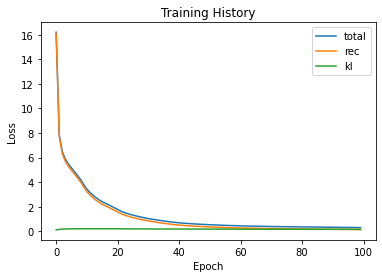

In [16]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec","kl"], loc="upper right")
plt.show()

## Testing

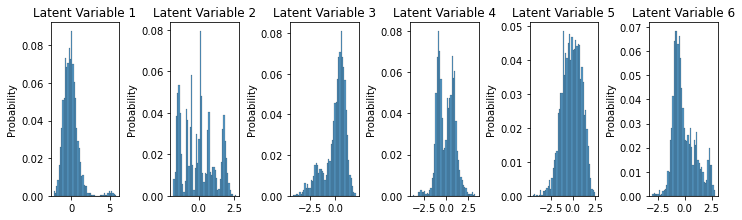

In [17]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1}")

In [18]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_num, loss_cat = get_reconstruction_loss(test_data, results, CAT_IDX, CAT_LENGTHS)
print(f"Numerical Variable Loss: {loss_num}")
print(f"Categorical Variable Loss: {loss_cat}")

Numerical Variable Loss: 3.0448474884033203
Categorical Variable Loss: 13.511985778808594


In [19]:
# Transform continuous/categorical variables back to real values in the results and test data
if len(CAT_LENGTHS) > 0:  
    # Handle case where are categorical variables
    results_num = scaler_pers_test.inverse_transform(results[0])
    test_data_num = scaler_pers_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

    # Argmax for each categorical variable the results data
    for i, x in enumerate(results[1]):
        result = np.argmax(x, axis=1) + 1
        results_df[f"{x}"] = result

    # Argmax for each categorical variable the test data
    current = CAT_IDX
    for i, x in enumerate(CAT_LENGTHS):
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{i}"] = test_data_cat
        current += x

else:
    # Handle case where there are no categorical variables
    results_num = scaler_pers_test.inverse_transform(results)
    test_data_num = scaler_pers_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

<ipython-input-20-28e81acb26e4>:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(h_pad=4)


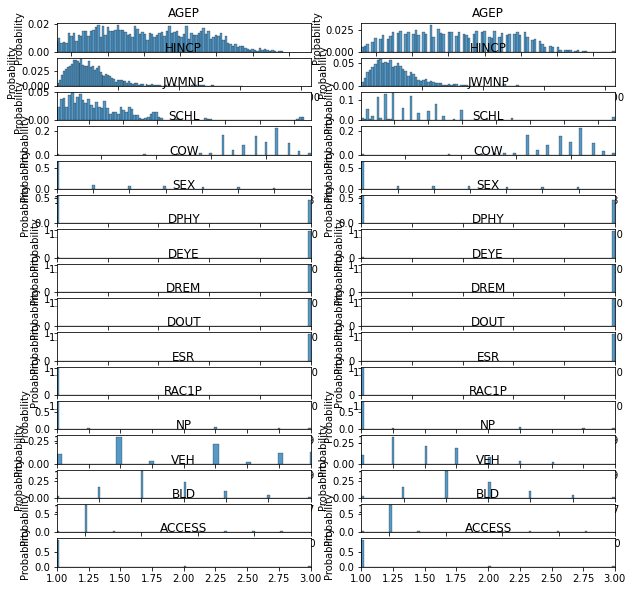

In [20]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,10))
fig.tight_layout(h_pad=4)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(test_data_df[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(test_data_df[col]),max(test_data_df[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)

## Generating Synthetic Population

In [21]:
# Load in the synthetic households
synth_hh_df = pd.read_csv('data/synthetic_populations/wa_households.csv')

# How many variables represent each household
HH_DIM = 5

# Create new column for copy of hh sizes and scale household input variables
sizes = synth_hh_df[['NP']]
synth_hh_df = pd.concat([synth_hh_df, sizes], axis=1)
synth_hh_df.columns = ['HINCP','NP','VEH','SIZE','BLD','ACCESS']

# Multiply the inputs by the number of persons per household (hh of size 3 becomes 3 rows with same scaled hh inputs)
synth_hh_df['HH_ID'] = synth_hh_df.index
synth_hh_df = synth_hh_df.reindex(synth_hh_df.index.repeat(synth_hh_df['SIZE']))
synth_hh_df_unscaled = synth_hh_df.copy()

# Scale the hh variables
synth_hh_df.iloc[:,:HH_DIM] = scaler_hh_test.fit_transform(synth_hh_df.iloc[:,:HH_DIM])
synth_hh_values = synth_hh_df.iloc[:,:HH_DIM]

del synth_hh_df

# How many synthetic households to fill
POP_SIZE = len(synth_hh_values)

In [22]:
# Generate random normal sample to represent each latent variable, for each row (different person per row)
epsilon = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

In [23]:
start_time = time.time()

In [24]:
# Generate persons; each person has unique latent input, plus shared hh inputs with their household
results = vae.decoder.predict([epsilon[0:1000000], synth_hh_values[0:1000000]])

In [25]:
print(f"--- {time.time() - start_time} seconds ---")

--- 38.92004609107971 seconds ---


In [26]:
# Transform continuous/categorical variables back to real values in the results and test data
if len(CAT_LENGTHS) > 0:  
    # Handle case where are categorical variables
    results_num = scaler_pers_test.inverse_transform(results[0])
    test_data_num = scaler_pers_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

    # Argmax for each categorical variable the results data
    for i, x in enumerate(results[1]):
        result = np.argmax(x, axis=1) + 1
        results_df[f"{i}"] = result
    current = CAT_IDX

    # Argmax for each categorical variable the test data
    for i, x in enumerate(CAT_LENGTHS):
        test_data_cat = test_data[:,current:(current + x)]
        test_data_cat = np.argmax(test_data_cat, axis=1) + 1
        test_data_df[f"{i}"] = test_data_cat
        current += x
else:
    # Handle case where there are no categorical variables
    results_num = scaler_pers_test.inverse_transform(results)
    test_data_num = scaler_pers_test.inverse_transform(test_data[:,:CAT_IDX])
    results_df = pd.DataFrame(results_num)
    test_data_df = pd.DataFrame(test_data_num)

# Add back original variables names to the results
results_df.columns = VAR_NAMES
test_data_df.columns = VAR_NAMES

# Add back household ids to the results
results_df['HH_ID'] = synth_hh_df_unscaled['HH_ID'].values[0:1000000]

# In the PUMS data, VEH is indexed from 0 (sensibly). However we have just added 1 to all cat vars, so remove it
results_df['VEH'] = results_df['VEH'] - 1

In [27]:
# Assign the control variables from the synthetic households to individuals (replace what came from the model)
for var in HH_VAR_NAMES[1:]:
    results_df[f"{var}"] = synth_hh_df_unscaled[f"{var}"].values[0:1000000]

In [28]:
# Save the synthesized persons
results_df.to_csv('data/synthetic_populations/wa_persons.csv', index=False)
results_df

,AGEP,HINCP,JWMNP,SCHL,COW,SEX,DPHY,DEYE,DREM,DOUT,ESR,RAC1P,NP,VEH,BLD,ACCESS,HH_ID
0,44.426346,35168.074,14.927186,22,7,2,2,2,2,2,1,6,3,3,3,3,0
1,44.841732,35168.074,-25.360790,20,1,2,2,2,2,2,1,1,3,3,3,3,0
2,32.078739,28004.370,39.977089,16,1,2,2,2,2,2,1,1,1,1,1,1,1
3,38.691925,28004.370,15.043621,22,6,1,2,2,2,2,1,1,1,1,1,1,1
4,38.310062,121230.664,1.368318,23,1,1,2,2,2,2,1,9,4,3,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,55.112118,88425.340,86.966187,12,1,1,1,2,2,2,1,1,2,2,1,2,309546
999996,54.442711,27730.102,36.516891,20,1,2,1,2,2,2,1,1,2,2,3,2,309547
999997,31.153708,27730.102,102.439789,20,3,2,2,2,2,2,1,6,2,2,3,2,309547
999998,25.935144,43242.492,11.836106,22,1,2,1,2,2,2,1,1,3,2,1,3,309548


<ipython-input-29-43e56f2f1974>:3: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(h_pad=20)


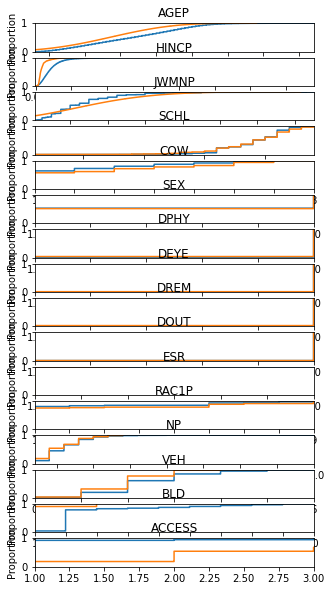

In [29]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=20)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=results_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)

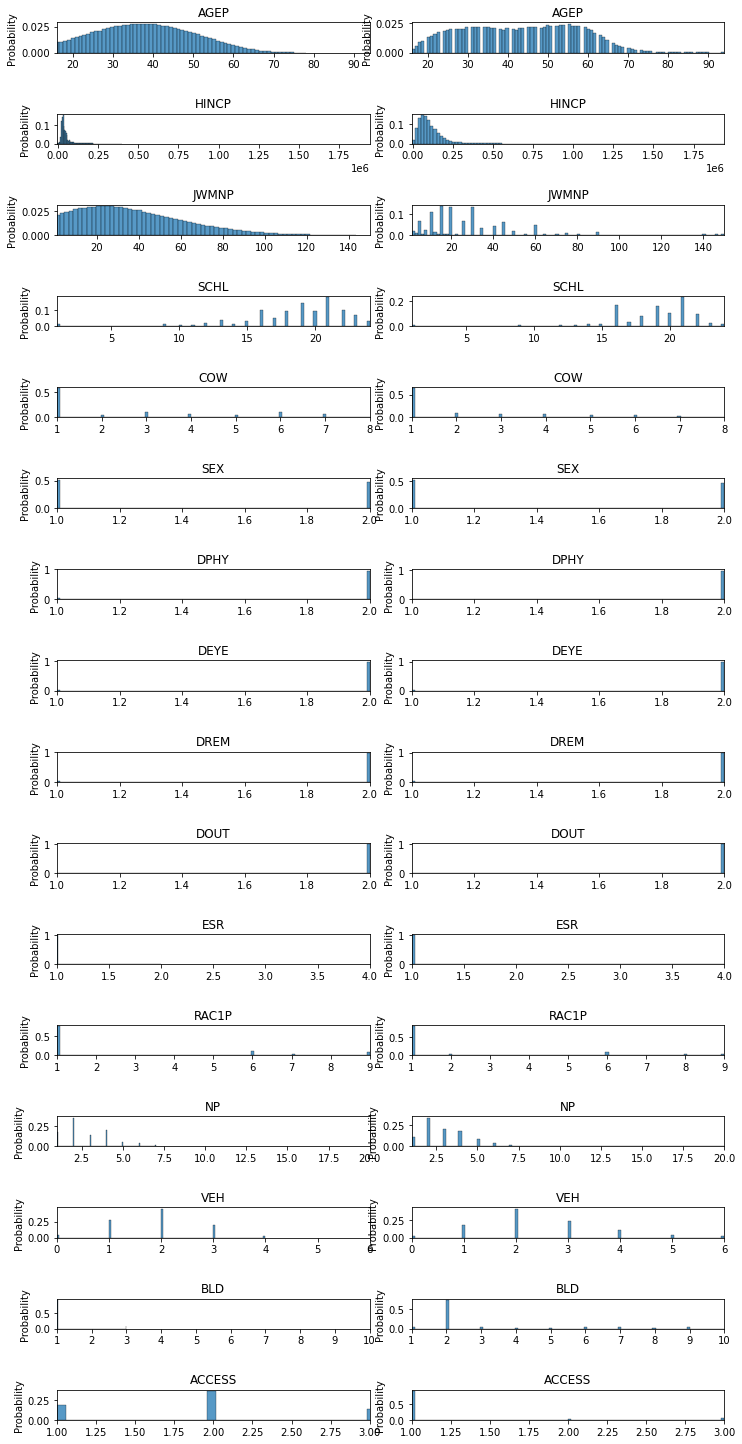

In [30]:
# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=2, figsize=(10,20))
fig.tight_layout(h_pad=4)

for i, col in enumerate(VAR_NAMES):
    sns.histplot(results_df[col], ax=axes[i,0], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,0].set_title(col)
    axes[i,0].set_xlabel(None)
    sns.histplot(pums_data[col], ax=axes[i,1], stat='probability', bins=100).set(xlim=(min(pums_data[col]),max(pums_data[col])))
    axes[i,1].set_title(col)
    axes[i,1].set_xlabel(None)